In [1]:
import pandas as pd
import numpy as np
import nltk
import os
import prepo_lib as prepo
from nltk.tokenize import sent_tokenize, word_tokenize
import tensorflow as tf
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [3]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from keras.models import Model
from gensim import models
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint
import keras.models
from keras.models import model_from_json
from flask import session
from datetime import datetime
import keras.regularizers 

In [4]:
dfmaster = pd.read_csv("data/masterdata.csv")
dfmaster['tokens'] = dfmaster['content'].apply(lambda x : prepo.case_folding(x))
dfmaster['tokens'] = dfmaster['tokens'].apply(lambda x : prepo.cleaning(x))
dfmaster['tokens'] = dfmaster['tokens'].apply(lambda x : prepo.slangword(x))
dfmaster['tokens'] = dfmaster['tokens'].apply(lambda x : prepo.stemming(x))
dfmaster['tokens'] = dfmaster['tokens'].apply(lambda x : prepo.ganti_negasi(x))
dfmaster['tokens'] = dfmaster['tokens'].apply(lambda x : prepo.removeStopword(x))
dfmaster['tokens'] = dfmaster['tokens'].apply(lambda x : prepo.tokenize(x))
dfmaster['score'].value_counts()

1    7207
5    5044
3    1316
Name: score, dtype: int64

In [5]:
dfmaster

,Unnamed: 0,content,score,tokens
0,7698,Aplikasi di buka loading paling lambat. Klu ad...,1,"[aplikasi, buka, loading, paling, lambat, kala..."
1,20089,susah login . padahal udah isi tgl lahir tapi ...,1,"[susah, login, padahal, isi, tanggal, lahir, m..."
2,4051,Aplikasi setelah di update malah eroor ...tida...,3,"[aplikasi, update, malah, eroor, hilang, scan,..."
3,45325,Kenapa sertipikat saya ko ga keluar,1,"[sertipikat, kok, masuk]"
4,49311,Nggak jelas,1,[rancu]
...,...,...,...,...
13562,18846,Gak bisa aplikasinya mentok di gambar kebijaka...,3,"[gagal, aplikasi, mentok, gambar, bijak, gerak]"
13563,4171,Nih aplikasih gimana sih!? Gua gk bisa login.....,1,"[nih, aplikasih, bagaimana, sih, gua, enggak, ..."
13564,22939,Dengan peduli lindungi sangat mudah registrasi...,5,"[peduli, lindung, sangat, mudah, registrasi, v..."
13565,59742,Good,5,[bagus]


In [78]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(dfmaster, test_size=0.2, shuffle =True)

#Training
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

#Test
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

data_test.to_csv('data/data_test.csv')
data_train.to_csv('data/data_test.csv')

145093 words total, with a vocabulary size of 13252
Max sentence length is 168
36832 words total, with a vocabulary size of 5567
Max sentence length is 113


In [80]:
data = pd.read_csv('data/data_train_label.csv')
data_test = pd.read_csv('data/data_test_label.csv')

In [42]:
sen = []
for l in data.score:
    if l == 5 :
        sen.append("Positif")
    elif l == 3 :
        sen.append("Netral")
    else :
        sen.append("Negatif")

data['sentimen']= sen

pos = []
net = []
neg = []
for l in data.sentimen:
    if l == "Positif":
        pos.append(1)
        net.append(0)
        neg.append(0)
    elif l == "Netral":
        pos.append(0)
        net.append(1)
        neg.append(0)
    elif l == "Negatif" :
        pos.append(0)
        net.append(0)
        neg.append(1)

data['Pos']= pos
data['Net']= net
data['Neg']= neg

In [81]:
#Prepo data train
data['casefolding'] = data['content'].apply(lambda x : prepo.case_folding(x))
data['cleaning'] = data['casefolding'].apply(lambda x : prepo.cleaning(x))
data['slang'] = data['cleaning'].apply(lambda x : prepo.slangword(x))
data['stemming'] = data['slang'].apply(lambda x : prepo.stemming(x))
data['negation'] = data['stemming'].apply(lambda x : prepo.ganti_negasi(x))
data['stopword'] = data['negation'].apply(lambda x : prepo.removeStopword(x))
data['tokenize'] = data['stopword'].apply(lambda x : prepo.tokenize(x))
data

,Unnamed: 0,content,label,Pos,Net,Neg,casefolding,cleaning,slang,stemming,negation,stopword,tokenize
0,0,Aplikasi pintar,2,1,0,0,aplikasi pintar,aplikasi pintar,aplikasi pintar,aplikasi pintar,aplikasi pintar,aplikasi pintar,"[aplikasi, pintar]"
1,1,KLAIM SERTIFIKAT VAKSIN RIBET BANGET WAKTU KLI...,0,0,0,1,klaim sertifikat vaksin ribet banget waktu kli...,klaim sertifikat vaksin ribet banget waktu kli...,klaim sertifikat vaksin ribet banget waktu kli...,klaim sertifikat vaksin ribet banget waktu kli...,klaim sertifikat vaksin ribet banget waktu kli...,klaim sertifikat vaksin ribet banget waktu kli...,"[klaim, sertifikat, vaksin, ribet, banget, wak..."
2,2,Mantul,2,1,0,0,mantul,mantul,mantul,mantul,mantul,mantul,[mantul]
3,3,"aplikasi apaan ini? ko gabisa masuk, percuma min",0,0,0,1,"aplikasi apaan ini? ko gabisa masuk, percuma min",aplikasi apaan ini ko gabisa masuk percuma min,aplikasi apaan ini kok enggak bisa masuk percu...,aplikasi apa ini kok enggak bisa masuk percuma...,aplikasi apa ini kok enggak bisa masuk percuma...,aplikasi apa kok enggak masuk percuma min,"[aplikasi, apa, kok, enggak, masuk, percuma, min]"
4,4,Kok punya ku Ndak terdaftar ya padahal aku dah...,1,0,1,0,kok punya ku ndak terdaftar ya padahal aku dah...,kok punya ku ndak terdaftar ya padahal aku dah...,kok punya aku tidak terdaftar ya padahal aku d...,kok punya aku tidak daftar ya padahal aku deh ...,kok punya aku tidak daftar ya padahal aku deh ...,kok punya aku daftar padahal aku deh faksin pe...,"[kok, punya, aku, daftar, padahal, aku, deh, f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10848,10848,Akun saya ada nik sy dan suami jg temen nya.gi...,1,0,1,0,akun saya ada nik sy dan suami jg temen nya.gi...,akun saya ada nik sy dan suami jg temen nya gi...,akun saya ada nik saya dan suami juga teman ny...,akun saya ada nik saya dan suami juga teman ny...,akun saya ada nik saya dan suami juga teman ny...,akun nik suami teman nya bagaimana cara hapus ...,"[akun, nik, suami, teman, nya, bagaimana, cara..."
10849,10849,Mohon maaf ngga bisa download sertifikatnya Se...,0,0,0,1,mohon maaf ngga bisa download sertifikatnya se...,mohon maaf ngga bisa download sertifikatnya se...,mohon maaf enggak bisa download sertifikatnya ...,mohon maaf enggak bisa download sertifikat sem...,mohon maaf enggak bisa download sertifikat sem...,mohon maaf enggak download sertifikat bintang ...,"[mohon, maaf, enggak, download, sertifikat, bi..."
10850,10850,gak ada kontak CS nya ya di aplikasinya???itu ...,1,0,1,0,gak ada kontak cs nya ya di aplikasinya???itu ...,gak ada kontak cs nya ya di aplikasinya itu ...,tidak ada kontak cs nya ya di aplikasinya itu ...,tidak ada kontak cs nya ya di aplikasi itu ser...,tidak tiada kontak cs nya ya di aplikasi itu ...,tiada kontak cs nya aplikasi sertifikat syaa t...,"[tiada, kontak, cs, nya, aplikasi, sertifikat,..."
10851,10851,Aplikasi yang memaksakan diri ... Lokasi ada p...,0,0,0,1,aplikasi yang memaksakan diri ... lokasi ada p...,aplikasi yang memaksakan diri lokasi ada p...,aplikasi yang memaksakan diri lokasi ada pilih...,aplikasi yang paksa diri lokasi ada pilih tapi...,aplikasi yang paksa diri lokasi ada pilih tapi...,aplikasi paksa diri lokasi pilih aktif terus p...,"[aplikasi, paksa, diri, lokasi, pilih, aktif, ..."


In [109]:
data.to_csv('data/data_train_prepo.csv', sep = ",")

In [6]:
data = pd.read_csv('data/data_train_prepo.csv',  sep=',')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [7]:
data_test = pd.read_csv('data/data_test_prepo.csv', on_bad_lines='skip')
data_test = data_test.loc[:, ~data_test.columns.str.contains('^Unnamed')]

In [10]:
data = pd.read_csv('data/data_train_prepo.csv')
data_test = pd.read_csv('data/data_test_prepo.csv')

In [9]:
EMBEDDING_DIM = 500
modelSG = Word2Vec(data['tokenize'], vector_size=EMBEDDING_DIM, window=3, min_count=0, sg=1, seed=2)
modelSG.wv.save_word2vec_format('data\model\saved_word2vec_sg_500.txt',binary=False)
modelCBOW = Word2Vec(data['tokenize'], vector_size=EMBEDDING_DIM, window=3, min_count=0, sg=0, seed=2)
modelCBOW.wv.save_word2vec_format('data\model\saved_word2vec_cbow_500.txt',binary=False)

In [21]:
#skipgram
#kaggle https://github.com/ML2021/TF-RNN-CNN-text-processing/blob/main/Multi%20Class%20Text%20Classification%20word2vec%20using%20CNN.ipynb
embeddings_index = {}
with open('data\model\saved_word2vec_sg.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] =coefs    

new_embedding = embeddings_index.get(word)

new_embedding

array([ 2.04779580e-03, -7.64556602e-03, -3.97945195e-03, -8.55395291e-03,
       -7.58602936e-03,  5.74827567e-03,  8.49650614e-03,  2.62630987e-03,
       -2.29515275e-03,  1.37257092e-02, -1.22246072e-02,  8.14954937e-03,
       -5.70583344e-03,  1.73452776e-02, -3.03364987e-03,  1.64364337e-03,
       -2.44861119e-04, -2.23404472e-03, -8.78692511e-03,  1.56605523e-02,
        9.81923845e-03, -3.47627862e-03, -5.48506901e-03, -3.80400568e-03,
        9.23173875e-03,  5.69002470e-03, -8.38039350e-03, -4.80684312e-03,
       -2.17502825e-02,  1.13794049e-02, -1.82339791e-02, -5.28322067e-03,
       -4.42219526e-03, -1.30799308e-05,  8.47309921e-03,  2.38405401e-03,
       -2.50548813e-02, -6.22687105e-04,  8.13663937e-04, -1.14417914e-02,
       -6.86552725e-04,  1.65466722e-02,  1.31335799e-02,  6.04528980e-03,
        1.83248725e-02,  1.25922915e-02,  1.62063283e-04, -1.80097371e-02,
        1.03213135e-02,  1.15976846e-02, -1.60306897e-02, -3.97619931e-03,
        2.33954079e-02, -

In [20]:
#cbow
embeddings_index = dict()
f = open('data\model\saved_word2vec_cbow.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [22]:
MAX_VOCAB_SIZE = 100
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(data['tokenize'].tolist())
train_word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(data["tokenize"].tolist())
test_sequences = tokenizer.texts_to_sequences(data_test["tokenize"].tolist())

In [23]:
#membentuk urutan yang akan menjadi input 
MAX_SEQUENCE_LENGTH = 100
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [24]:
# Prepare embedding matrix from pre-trained model
EMBEDDING_DIM = 500
embedding_matrix = np.zeros((len(train_word_index)+1,EMBEDDING_DIM))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
embedding_matrix = np.zeros((len(train_word_index)+1,EMBEDDING_DIM))
#pembobotan kta pada train
for word, i in train_word_index.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = new_embedding
    if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
      # nilai 0 juga termasuk padding pada saat sequence
      embedding_matrix[i] = embedding_vector

In [28]:
label_names = ['Pos', 'Net','Neg']

y_train = data[label_names].values
x_train = train_cnn_data

In [29]:
import pickle

with open('data\model\Saved_Tokenize.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
#FIX BANGETT
#PARAMETER
FILTERS_SIZE = 50
KERNEL_SIZE = 5
LEARNING_RATE = 0.0001

model = Sequential()
model.add(Embedding(input_dim=len(train_word_index)+1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Conv1D(FILTERS_SIZE, KERNEL_SIZE, strides=1, activation='relu', padding='same' , input_shape =(x_train.shape[1],) , kernel_regularizer=keras.regularizers.l2(0.02)))
#model.add(Conv1D(FILTERS_SIZE, KERNEL_SIZE, strides=1, activation='relu', padding='same' , kernel_regularizer=keras.regularizers.L1(0.01), activity_regularizer=keras.regularizers.L2(0.01)))
model.add(MaxPooling1D(2))
model.add(Dropout(0.05))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(LEARNING_RATE), metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 500)          3129000   
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 50)           125050    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 50)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 flatten_1 (Flatten)         (None, 2500)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 20008     
                                                      

In [49]:
from gc import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

num_epochs = 120
batch_size = 64

es_callback =EarlyStopping(monitor='val_loss', patience=20, verbose=1)
# filePath = "data/model/callback_sentimen_sg.h5"
# m_checkpoint = ModelCheckpoint(filePath, monitor='val_loss',
#                              mode='min',
#                              save_best_only=True,
#                              verbose=1)
# print('Start training model........')

hist = model.fit(x_train, y_train, epochs=num_epochs, validation_split=0.2, shuffle=True , batch_size=batch_size, callbacks=es_callback)

Epoch 1/120
136/136 [==============================] - 18s 125ms/step - loss: 2.2422 - acc: 0.5218 - val_loss: 1.6683 - val_acc: 0.5297
Epoch 2/120
136/136 [==============================] - 15s 112ms/step - loss: 1.3920 - acc: 0.5419 - val_loss: 1.1458 - val_acc: 0.5297
Epoch 3/120
136/136 [==============================] - 16s 115ms/step - loss: 1.0595 - acc: 0.6006 - val_loss: 0.9424 - val_acc: 0.6753
Epoch 4/120
136/136 [==============================] - 23s 172ms/step - loss: 0.9301 - acc: 0.6359 - val_loss: 0.8669 - val_acc: 0.6582
Epoch 5/120
136/136 [==============================] - 23s 172ms/step - loss: 0.8803 - acc: 0.6360 - val_loss: 0.8373 - val_acc: 0.6753
Epoch 6/120
136/136 [==============================] - 21s 155ms/step - loss: 0.8667 - acc: 0.6331 - val_loss: 0.8303 - val_acc: 0.6753
Epoch 7/120
136/136 [==============================] - 23s 169ms/step - loss: 0.8562 - acc: 0.6417 - val_loss: 0.8238 - val_acc: 0.6753
Epoch 8/120
136/136 [===========================

In [32]:
predictions = model.predict(test_cnn_data, batch_size=8, verbose=1)
print(predictions)

340/340 [==============================] - 2s 7ms/step
[[0.6257322  0.07492743 0.2993404 ]
 [0.1089293  0.11083267 0.7802381 ]
 [0.593006   0.07937194 0.32762206]
 ...
 [0.10934156 0.11286421 0.77779424]
 [0.593006   0.07937194 0.32762206]
 [0.593006   0.07937194 0.32762206]]


In [33]:
review = pd.DataFrame(data_test.stopword)
lab = pd.DataFrame(data_test.sentimen)

In [34]:
text = review.values
lb = lab.values
print(lb)

[['Positif']
 ['Negatif']
 ['Negatif']
 ...
 ['Negatif']
 ['Positif']
 ['Positif']]


In [35]:
class_category = ['POSITIF','NETRAL','NEGATIF']

In [36]:
rev = []
lbl = []
pred = []
for i in range(predictions.shape[0]):
    review = text[i]
    lbe = lb[i]
    pre = class_category[predictions[i].argmax()]
    
    print(str( i)+" "+pre+" "+lbe+" | "+str(review))
    rev.append(review)
    lbl.append(lbe)
    pred.append(pre)

b = {'content' : rev, 'label' : lbl, 'predict' : pred}
df = pd.DataFrame(b)


["0 POSITIF Positif | ['suka']"]
["1 NEGATIF Negatif | ['aplikasi sampah susah masuk sekali nya masuk arah masuk tanggal lahir gilir masuk gagal aplikasi pedulilindungi aplikasi sangat jelek']"]
["2 POSITIF Negatif | ['aplikasi kesal']"]
["3 NEGATIF Netral | ['coba dulu masuk tanggal lahir nya gagal mohon baru kak']"]
["4 POSITIF Negatif | ['aplikasi tolol']"]
["5 NEGATIF Positif | ['baik ecek keluarga kartu keluarga jadi biar lebih efisien mendownload tiap perangkat per ktp terimakasih']"]
["6 POSITIF Positif | ['sangat bantu tiap jalan kena status wilayah']"]
["7 NEGATIF Negatif | ['daftar vaksin pertama sertifikat temu']"]
["8 NEGATIF Negatif | ['gagal verifikasi susah jrlek kesel gwa']"]
["9 NEGATIF Negatif | ['aplikasi buat mana sih error mulu tiap scan luar radius mulu']"]
['10 POSITIF Positif | [nan]']
["11 NEGATIF Negatif | ['kok sekarang eror sih masa sepi cekout cekout sendiri']"]
["12 NEGATIF Negatif | ['aplikasi cacat rilis banyak bug sertifikat vaksin tenggelam sekarang pa

In [166]:
df.to_csv('data/hasil_prediksi_non.csv')

In [37]:
labels = ['Positif','Netral','Negatif']
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [38]:
ab = 0
ac = 0
aa = 0
for i in (lb):
    if i == 'Positif':
        ab = ab+1
    if i == 'Negatif':
        aa = aa+1
    if i == 'Netral':
        ac = ac+1
print ("netral : "+str(ac))
print ("negative : "+str(aa))
print ("postive : "+str(ab))

netral : 375
negative : 1451
postive : 888


In [39]:
from sklearn.metrics import confusion_matrix
labels = ['Negatif','Netral','Positif']
cf_kategori = pd.DataFrame(
    data=confusion_matrix(lb, prediction_labels, labels=labels),
    columns=labels,
    index=labels
)
print(cf_kategori)

         Negatif  Netral  Positif
Negatif     1062       0      389
Netral       170       0      205
Positif      188       0      700


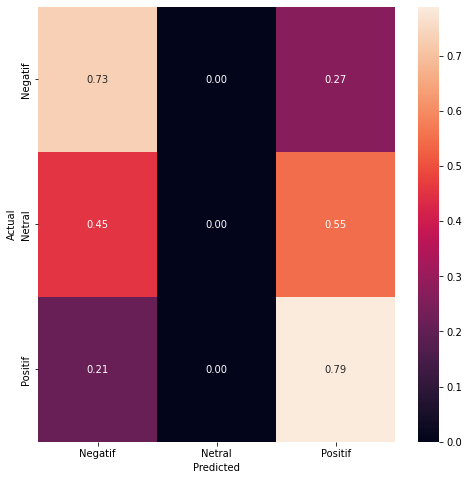

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(lb, prediction_labels)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [41]:
from sklearn.metrics import classification_report
label = ['Positif','Negatif','Netral']
print(classification_report(data_test['sentimen'].tolist(),prediction_labels,labels=label))

              precision    recall  f1-score   support

     Positif       0.54      0.79      0.64       888
     Negatif       0.75      0.73      0.74      1451
      Netral       0.00      0.00      0.00       375

    accuracy                           0.65      2714
   macro avg       0.43      0.51      0.46      2714
weighted avg       0.58      0.65      0.61      2714



c:\Users\ANDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ANDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ANDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

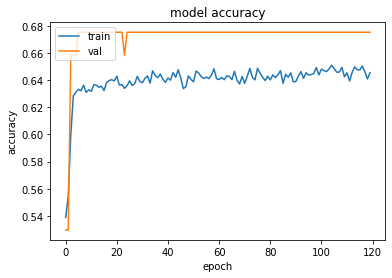

In [42]:
# summarize hist for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


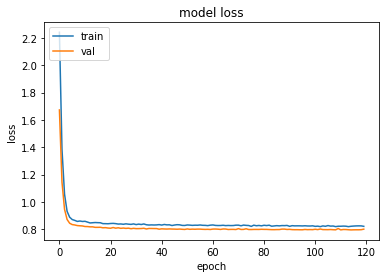

In [43]:
# summarize hist for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
text = ['suka']
sequences = tokenizer.texts_to_sequences([text])  # untuk meprediksi kata tetangga
print('sequences :', sequences)

test_cnn_data = pad_sequences(
    sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = test_cnn_data
print('x_test :', x_test)

#predictions = model.predict(x_test)
predictions1 = model.predict(x_test)
print(predictions1)
print(predictions1.argmax())

sequences : [[]]
x_test : [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 24ms/step
[[0.6257322  0.07492743 0.2993404 ]]
0


In [47]:
tokenizer.word_index

{"'aplikasi'": 1,
 "'vaksin'": 2,
 "'gagal'": 3,
 "'sertifikat'": 4,
 "'nya'": 5,
 "'masuk'": 6,
 "'bagus'": 7,
 "'sangat'": 8,
 "'mau'": 9,
 "'enggak'": 10,
 "'baik'": 11,
 "'padahal'": 12,
 "'tiada'": 13,
 "'buka'": 14,
 "'bantu'": 15,
 "'terus'": 16,
 "'daftar'": 17,
 "'kok'": 18,
 "'kali'": 19,
 "'bagaimana'": 20,
 "'tanggal'": 21,
 "'susah'": 22,
 "'data'": 23,
 "'buat'": 24,
 "'malah'": 25,
 "'jadi'": 26,
 "'banget'": 27,
 "'apa'": 28,
 "'sama'": 29,
 "'lahir'": 30,
 "'hp'": 31,
 "'pakai'": 32,
 "'nik'": 33,
 "'hilang'": 34,
 "'keluar'": 35,
 "'login'": 36,
 "'tetap'": 37,
 "'sih'": 38,
 "'mohon'": 39,
 "'pertama'": 40,
 "'bikin'": 41,
 "'mantap'": 42,
 "'email'": 43,
 "'kasih'": 44,
 "'sekali'": 45,
 "'update'": 46,
 "'cek'": 47,
 "'coba'": 48,
 "'kode'": 49,
 "'download'": 50,
 "'muncul'": 51,
 "'benar'": 52,
 "'selalu'": 53,
 "'baru'": 54,
 "'isi'": 55,
 "'mana'": 56,
 "'pas'": 57,
 "'kalo'": 58,
 "'ribet'": 59,
 "'mudah'": 60,
 "'salah'": 61,
 "'otp'": 62,
 "'sia'": 63,
 "'li

In [ ]:
import pickle
# with open('data\model\Saved_Tokenize.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model_json = model.to_json()
with open('data\model\saved_model_sentimen_sg1.json','w') as json_file:
    json_file.write(model_json)

model.save_weights("data\model\saved_model_sentimen_sg1.h5")

In [209]:
model.save("data\model\saved_model_sentimen_sg1.h5")